# Merton Jump Diffusion Model for DAX Index Options

In [949]:
from pylab import plt
import pandas as pd
import numpy as np
plt.style.use('seaborn-v0_8')
%matplotlib inline

import requests
import cufflinks
import pandas as pd
from io import StringIO
from eod import EodHistoricalData
cufflinks.set_config_file(offline=True)

import warnings
warnings.simplefilter('ignore')

from BSM_imp_vol import call_option
from BSM_imp_vol import put_option

In [835]:
import math
import numpy as np
from scipy.integrate import quad

def M76_characteristic_function(u, T, r, sigma, lamb, mu, delta):
    omega = r - 0.5 * sigma ** 2 - lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    value = np.exp((1j * u * omega - 0.5 * u ** 2 * sigma ** 2 +
            lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1))  * T)
    return value


def M76_integration_function(u, S0, K, T, r, sigma, lamb, mu, delta):
    JDCF = M76_characteristic_function(u - 0.5 * 1j, T, r,
                                       sigma, lamb, mu, delta)
    value = 1 / (u ** 2 + 0.25) * (np.exp(1j * u * math.log(S0 / K))
                                    * JDCF).real
    return value


def M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta):
    int_value = quad(lambda u: M76_integration_function(u, S0, K, T, r,
                    sigma, lamb, mu, delta), 0, 50, limit=250)[0]
    call_value = S0 - np.exp(-r * T) * math.sqrt(S0 * K) / math.pi * int_value
    return call_value

def M76_value_put_INT(S0, K, T, r, sigma, lamb, mu, delta):
    int_value = quad(lambda u: M76_integration_function(u, S0, K, T, r,
                    sigma, lamb, mu, delta), 0, 50, limit=250)[0]
    call_value = np.exp(-r * T) * math.sqrt(S0 * K) - S0 / math.pi * int_value
    return call_value

In [837]:
S0 = 100.0                  # initial index level
K = 100.0                   # strike level
T = 1.0                     # call option maturity
r = 0.05                    # constant short rate
sigma = 0.4                 # constant volatility of diffusion
lamb = 1.0                  # jump frequency p.a.
mu = -0.2                   # expected jump size
delta = 0.1                 # jump size volatility 

print ('Value of Call Option %8.3f' \
            % M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta))

print ('Value of Put Option %8.3f' \
            % M76_value_put_INT(S0, K, T, r, sigma, lamb, mu, delta))

Value of Call Option   19.948
Value of Put Option   10.966


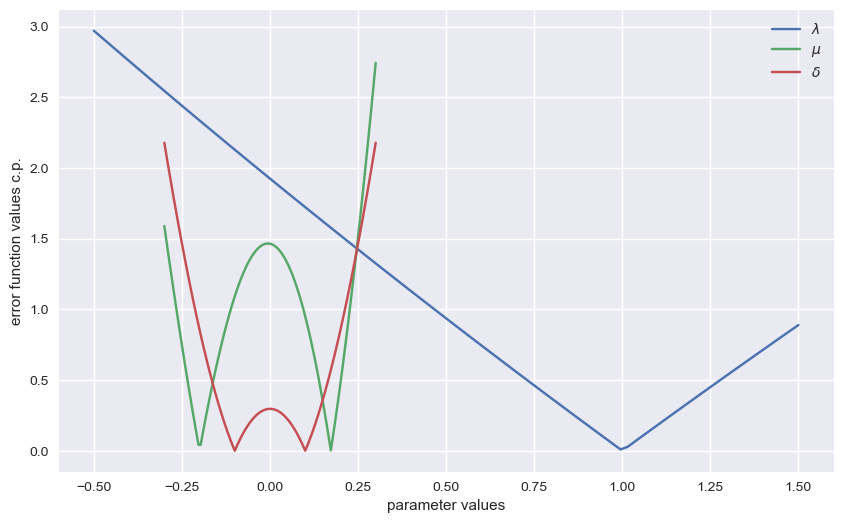

In [11]:
C0 = M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta)
def error_function(p0):
    sigma, lamb, mu, delta = p0
    return abs(C0 - M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta))


def plot_error_function():
    plt.figure(figsize=(10, 6))
    # Plotting (lamb)
    l = np.linspace(-0.5, 1.5, 100); EFv = []
    for i in l:
        EFv.append(error_function([sigma, i, mu, delta]))
    plt.plot(l, EFv, label='$\lambda$')
    plt.xlabel('parameter values')
    plt.ylabel('error function values c.p.')
    # Plotting (mu)
    l = np.linspace(-0.3, 0.3, 100); EFv = []
    for i in l:
        EFv.append(error_function([sigma, lamb, i, delta]))
    plt.plot(l, EFv, label='$\mu$')
    # Plotting (delta)
    l = np.linspace(-0.3, 0.3, 100); EFv = []
    for i in l:
        EFv.append(error_function([sigma, lamb, mu, i]))
    plt.plot(l, EFv, label='$\delta$')
    plt.legend(loc=0)

plot_error_function()

## Historical Data Import - Dax Index and Option Values

In [355]:
Start = pd.Timestamp('2020-05-15')
End =  pd.Timestamp('2020-06-19')

S0 = 10337.02                     # DAX level
r = 0.0                           # Assumption (Base Rate GER) // Derived from BSM using implied vola per Base Data

df = pd.read_csv('ref_eikon_option_data_adj_II.csv', index_col=0).dropna()
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Maturity'] = pd.to_datetime(df['Maturity'], dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 378 entries, 1 to 378
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Instrument  378 non-null    object        
 1   Date        378 non-null    datetime64[ns]
 2   Maturity    378 non-null    datetime64[ns]
 3   PUTCALLIND  378 non-null    object        
 4   Strike      378 non-null    int64         
 5   Close       378 non-null    float64       
 6   Imp_Vol     378 non-null    float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(2)
memory usage: 23.6+ KB


In [357]:
df.head()

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol
1,/GDAX20000F0.EX,2020-05-15,2020-06-19,CALL,2000,8323.3,203.25
2,/GDAX20000R0.EX,2020-05-15,2020-06-19,PUT,2000,0.1,150.50
3,/GDAX36000F0.EX,2020-05-15,2020-06-19,CALL,3600,6722.5,130.77
4,/GDAX36000R0.EX,2020-05-15,2020-06-19,PUT,3600,0.4,102.66
5,/GDAX40000F0.EX,2020-05-15,2020-06-19,CALL,4000,6322.5,118.17


In [359]:
df.tail()

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol
374,/GDAX180000R0.EX,2020-05-15,2020-06-19,PUT,18000,7689.0,65.37
375,/GDAX185000F0.EX,2020-05-15,2020-06-19,CALL,18500,0.1,51.70
376,/GDAX185000R0.EX,2020-05-15,2020-06-19,PUT,18500,8189.4,68.53
377,/GDAX190000F0.EX,2020-05-15,2020-06-19,CALL,19000,0.1,53.91
378,/GDAX190000R0.EX,2020-05-15,2020-06-19,PUT,19000,8689.8,71.82


In [361]:
print(df.loc[[163]])

           Instrument       Date   Maturity PUTCALLIND  Strike  Close  Imp_Vol
163  /GDAX100500F0.EX 2020-05-15 2020-06-19       CALL   10050  607.2    35.45


## Implied Volatilities per the Base Data Set

In [364]:
def calculate_imp_vols(data):
    ''' Calculate all implied volatilities for the European call options
    given the tolerance level for moneyness of the option.'''
    data['Imp_Vol'] = 0.0
    tol = 0.30  # tolerance for moneyness
    for row in data.index:
        t = data['Date'][row]
        T = data['Maturity'][row]
        ttm = (T - t).days / 365.
        forward = np.exp(r * ttm) * S0
        if (abs(data['Strike'][row] - forward) / forward) < tol:
            call = call_option(S0, data['Strike'][row], t, T, r, 0.2)
            data['Imp_Vol'][row] = call.imp_vol(data['Call'][row])
    return data

In [366]:
markers = ['.', 'o', '^', 'v', 'x', 'D', 'd', '>', '<']

In [368]:
def plot_imp_vols(data):
    ''' Plot the implied volatilites. '''
    maturities = sorted(set(data['Maturity']))
    plt.figure(figsize=(10, 6))
    for i, mat in enumerate(maturities):
        dat = data[(data['Maturity'] == mat) & (data['Imp_Vol'] > 0)]
        plt.plot(dat['Strike'].values, dat['Imp_Vol'].values,
                 'b%s' % markers[i], label=str(mat)[:10])
    plt.grid(True)
    plt.legend()
    plt.xlabel('strike')
    plt.ylabel('implied volatility')
    plt.show()

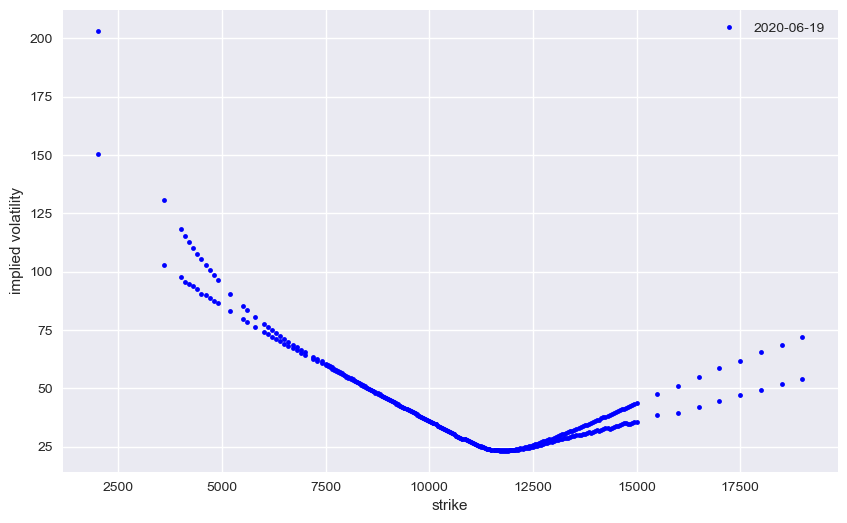

In [370]:
# Implied Volas from Base Data
plot_imp_vols(df)

In [372]:
# Separation of Puts & Call in Imp Vola Plot ---------------------------- #

def plot_imp_vols_sep(data):
    ''' Plot the implied volatilites. '''
    maturities = sorted(set(data['Maturity']))
    plt.figure(figsize=(10, 6))
    for i, mat in enumerate(maturities):
        dat = data[(data['Maturity'] == mat) & (data['Imp_Vol'] > 0) & (data['PUTCALLIND'] == 'CALL')]
        plt.plot(dat['Strike'].values, dat['Imp_Vol'].values,
                 'r%s' % markers[i], label=str('CALLS')[:10])
    for i, mat in enumerate(maturities):
        dat = data[(data['Maturity'] == mat) & (data['Imp_Vol'] > 0) & (data['PUTCALLIND'] == 'PUT ')]
        plt.plot(dat['Strike'].values, dat['Imp_Vol'].values,
                 'b%s' % markers[i], label=str('PUTS')[:10])
    plt.grid(True)
    plt.legend()
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.tight_layout()
    plt.savefig('Imp_Volas_DAX_Base Data.png')

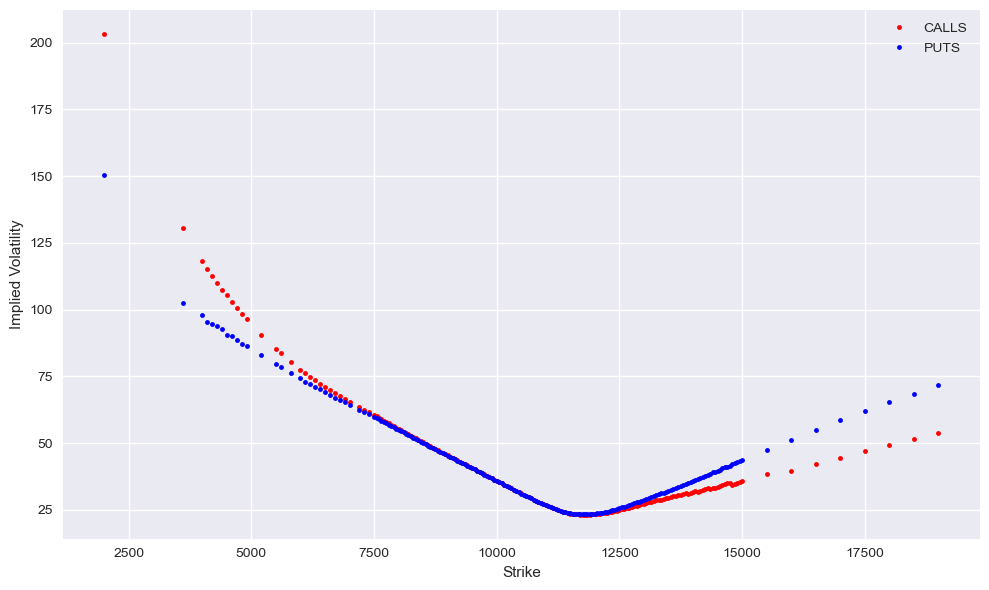

In [374]:
plot_imp_vols_sep(df)

In [376]:
Calls = df['PUTCALLIND'] == 'CALL'
Puts = df['PUTCALLIND'] == 'PUT '

df_call = df[~Puts]
df_put = df[~Calls]

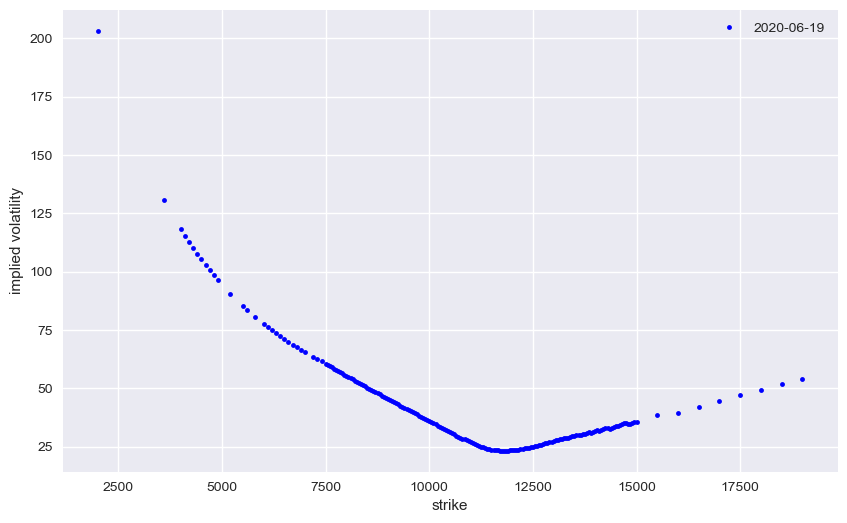

In [378]:
plot_imp_vols(df_call)

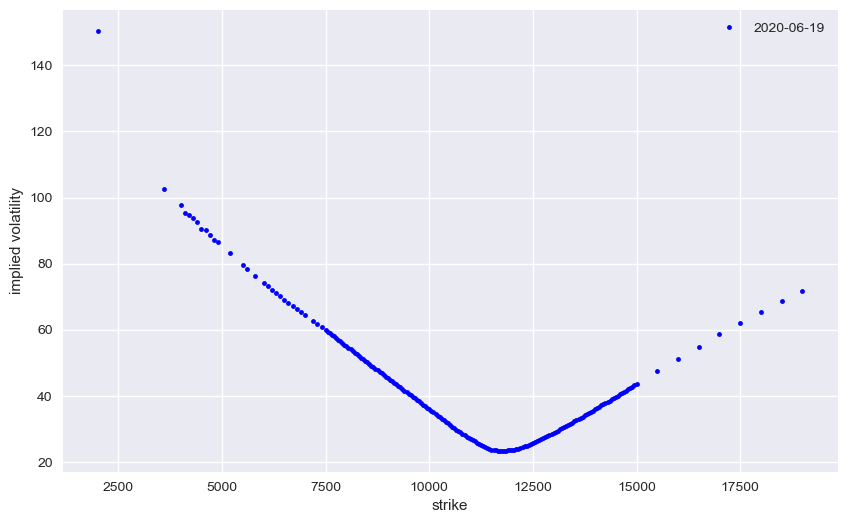

In [380]:
plot_imp_vols(df_put)

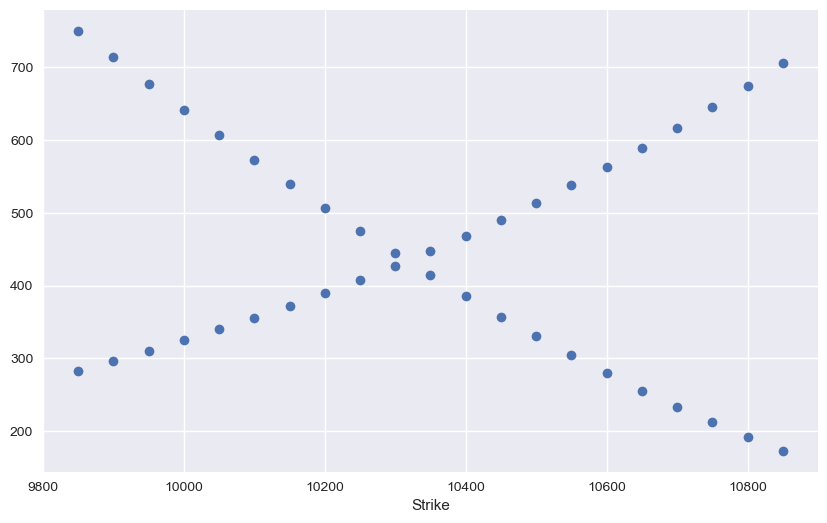

In [382]:
# Option Selection (from Calls & Puts)
tol = 0.05
options = df[(np.abs(df['Strike'] - S0) / S0) < tol]
mats = sorted(set(options['Maturity']))
options = options[options['Maturity'] == mats[0]]
options

options.set_index('Strike')['Close'].plot(style='o', figsize=(10, 6));

In [384]:
# Option Selection (from Calls only)
tol = 0.05
options_call = df_call[(np.abs(df_call['Strike'] - S0) / S0) < tol]
mats = sorted(set(options_call['Maturity']))
options_call = options_call[options_call['Maturity'] == mats[0]]
options_call

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol
155,/GDAX98500F0.EX,2020-05-15,2020-06-19,CALL,9850,750.4,37.36
157,/GDAX99000F0.EX,2020-05-15,2020-06-19,CALL,9900,713.7,36.87
159,/GDAX99500F0.EX,2020-05-15,2020-06-19,CALL,9950,677.5,36.40
161,/GDAX100000F0.EX,2020-05-15,2020-06-19,CALL,10000,642.0,35.92
163,/GDAX100500F0.EX,2020-05-15,2020-06-19,CALL,10050,607.2,35.45
165,/GDAX101000F0.EX,2020-05-15,2020-06-19,CALL,10100,573.1,34.97
167,/GDAX101500F0.EX,2020-05-15,2020-06-19,CALL,10150,539.7,34.49
169,/GDAX102000F0.EX,2020-05-15,2020-06-19,CALL,10200,507.2,34.02
171,/GDAX102500F0.EX,2020-05-15,2020-06-19,CALL,10250,475.4,33.53
173,/GDAX103000F0.EX,2020-05-15,2020-06-19,CALL,10300,444.5,33.06


<Axes: xlabel='Strike'>

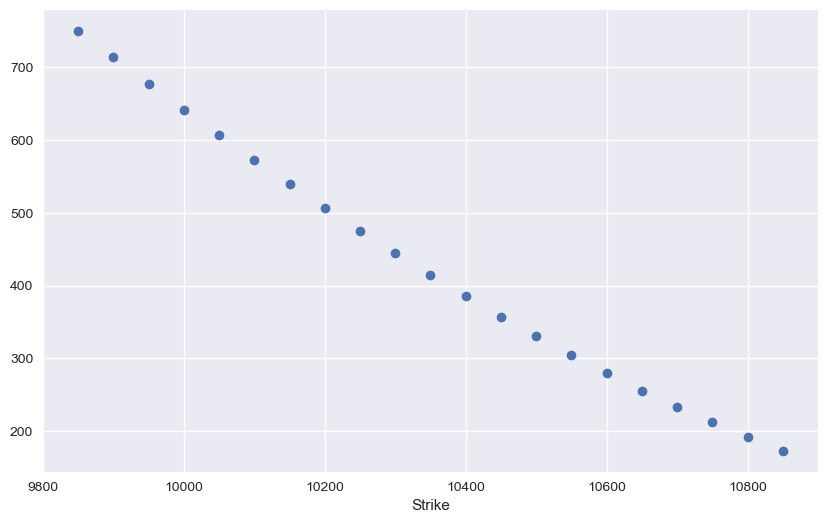

In [386]:
options_call.set_index('Strike')['Close'].plot(style='o', figsize=(10, 6))

<Axes: xlabel='Strike'>

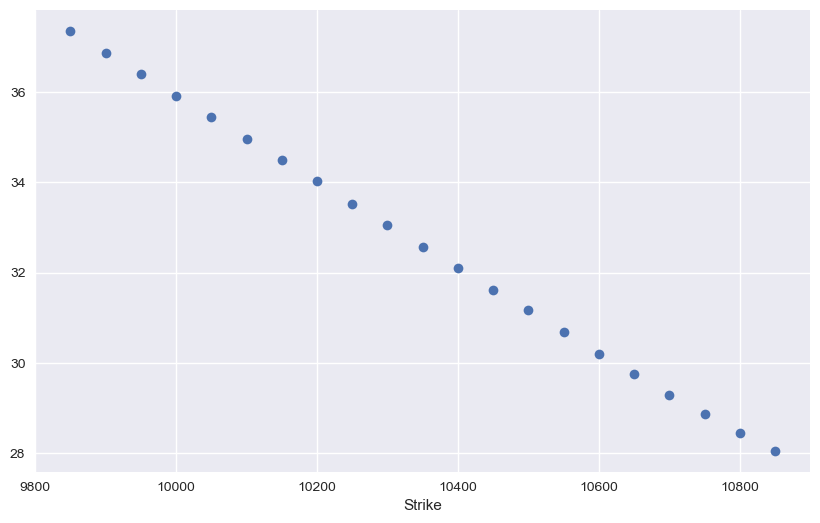

In [388]:
options_call.set_index('Strike')['Imp_Vol'].plot(style='o', figsize=(10, 6))

# Optimization of the Merton Model for Call Options

In [390]:
i = 0; min_RMSE = 100.
def M76_error_function(p0):
    global i, min_RMSE
    sigma, lamb, mu, delta = p0
    if sigma < 0.0 or delta < 0.0 or lamb < 0.0:
        return 500.0
    se = []
    for row, option in options_call.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        model_value = M76_value_call_INT(S0, option['Strike'], T,
                                         r, sigma, lamb, mu, delta)
        se.append((model_value - option['Close']) ** 2)
    RMSE = math.sqrt(sum(se) / len(se))
    min_RMSE = min(min_RMSE, RMSE)
    if i % 100 == 0:
        print ('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (RMSE, min_RMSE))
    i += 1
    return RMSE

In [392]:
%%time
import scipy.optimize as sop
np.set_printoptions(suppress=True,
                    formatter={'all': lambda x: '%6.3f' % x})
p0 = sop.brute(M76_error_function, ((0.10, 0.25, 0.025),
                   (0.10, 0.80, 0.10), (-0.40, 0.00, 0.10),
                   (0.00, 0.12, 0.02)), finish=None)

   0 | [ 0.100  0.100 -0.400  0.000] | 246.820 | 100.000
 100 | [ 0.100  0.500 -0.400  0.080] | 180.807 | 100.000
 200 | [ 0.125  0.200 -0.300  0.040] | 215.517 | 100.000
 300 | [ 0.125  0.600 -0.200  0.000] | 193.021 | 100.000
 400 | [ 0.150  0.300 -0.200  0.080] | 191.567 | 100.000
 500 | [ 0.150  0.700 -0.100  0.040] | 193.148 | 100.000
 600 | [ 0.175  0.500 -0.400  0.000] | 108.601 | 100.000
 700 | [ 0.200  0.200 -0.400  0.080] | 128.971 |  75.824
 800 | [ 0.200  0.600 -0.300  0.040] |  91.432 |  66.391
 900 | [ 0.225  0.300 -0.200  0.000] | 110.637 |  50.286
1000 | [ 0.225  0.700 -0.200  0.080] |  84.529 |  24.673
CPU times: total: 44.8 s
Wall time: 54.6 s


In [394]:
%%time
opt = sop.fmin(M76_error_function, p0, xtol=0.00001,
                    ftol=0.00001, maxiter=750, maxfun=1500)

1100 | [ 0.224  0.749 -0.458  0.000] |   4.031 |   4.031
1200 | [ 0.217  1.092 -0.333  0.000] |   3.513 |   3.513
1300 | [ 0.207  1.548 -0.261  0.000] |   2.820 |   2.820
1400 | [ 0.198  2.029 -0.221  0.001] |   1.984 |   1.984
1500 | [ 0.180  2.869 -0.183  0.001] |   0.672 |   0.672
1600 | [ 0.177  3.051 -0.177  0.001] |   0.390 |   0.390
Optimization terminated successfully.
         Current function value: 0.389896
         Iterations: 390
         Function evaluations: 653
CPU times: total: 29.1 s
Wall time: 35.7 s


In [396]:
i = 0
M76_error_function(p0)

   0 | [ 0.225  0.700 -0.400  0.000] |  24.673 |   0.390


24.672962184508393

In [398]:
i = 0
M76_error_function(opt)

   0 | [ 0.177  3.052 -0.177  0.001] |   0.390 |   0.390


0.38989619526231417

# Estimation of the Call Premiums vs Market Premiums

In [400]:
def generate_plot(opt, options_call):
    sigma, lamb, mu, delta = opt
    options_call['Model'] = 0.0
    for row, option in options_call.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        options_call.loc[row, 'Model'] = M76_value_call_INT(S0, option['Strike'],
                                    T, r, sigma, lamb, mu, delta)
    options_call = options_call.set_index('Strike')
    fig, ax = plt.subplots(2, sharex=True, figsize=(8, 7))
    options_call[['Close', 'Model']].plot(style=['b-', 'ro'],
                    title='%s' % str(option['Maturity'])[:10], ax=ax[0])
    ax[0].set_ylabel('option values')
    xv = options_call.index.values
    ax[1] = plt.bar(xv - 5 / 2., options_call['Model'] - options_call['Close'], 
                    width=5)
    plt.ylabel('difference')
    plt.xlim(min(xv) - 10, max(xv) + 10)
    plt.tight_layout()

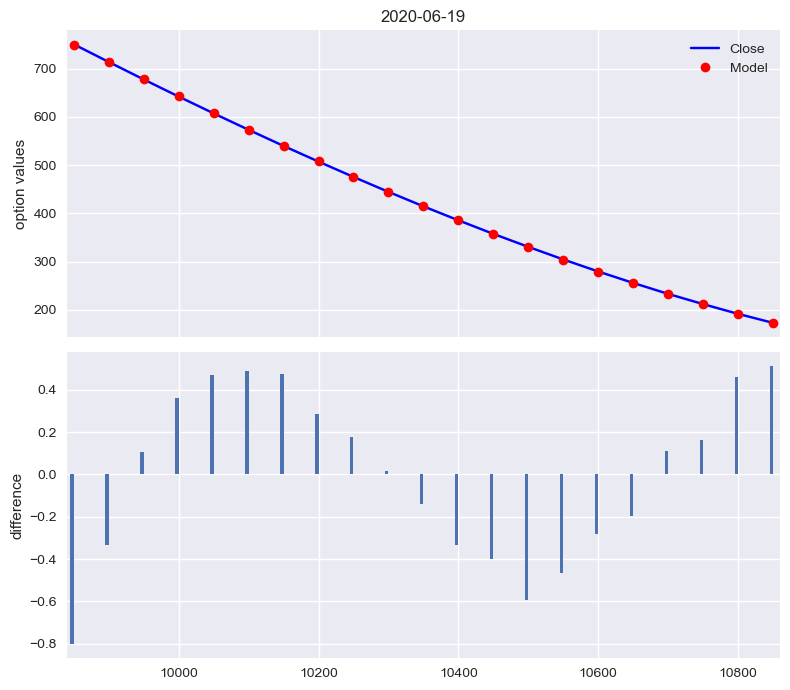

In [402]:
generate_plot(opt, options_call)

In [404]:
options_call

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,Model
155,/GDAX98500F0.EX,2020-05-15,2020-06-19,CALL,9850,750.4,37.36,749.596966
157,/GDAX99000F0.EX,2020-05-15,2020-06-19,CALL,9900,713.7,36.87,713.366521
159,/GDAX99500F0.EX,2020-05-15,2020-06-19,CALL,9950,677.5,36.40,677.607396
161,/GDAX100000F0.EX,2020-05-15,2020-06-19,CALL,10000,642.0,35.92,642.360112
163,/GDAX100500F0.EX,2020-05-15,2020-06-19,CALL,10050,607.2,35.45,607.670928
165,/GDAX101000F0.EX,2020-05-15,2020-06-19,CALL,10100,573.1,34.97,573.591133
167,/GDAX101500F0.EX,2020-05-15,2020-06-19,CALL,10150,539.7,34.49,540.176173
169,/GDAX102000F0.EX,2020-05-15,2020-06-19,CALL,10200,507.2,34.02,507.484627
171,/GDAX102500F0.EX,2020-05-15,2020-06-19,CALL,10250,475.4,33.53,475.577079
173,/GDAX103000F0.EX,2020-05-15,2020-06-19,CALL,10300,444.5,33.06,444.514909


## Estimation of the Model's Implied Volatilities

In [406]:
def calc_imp_vols(data):
    data['Imp_Vol_Mod'] = 0.0
    data['Imp_Vol_Mar'] = 0.0
    tol = 0.30  # tolerance for moneyness
    for row in data.index:
        t = data['Date'][row]
        T = data['Maturity'][row]
        ttm = (T - t).days / 365.
        forward = np.exp(r * ttm) * S0
        if (abs(data['Strike'][row] - forward) / forward) < tol:
            call = call_option(S0, data['Strike'][row], t, T, r, 0.2)
            data['Imp_Vol_Mod'][row] = call.imp_vol(data['Model'][row])
            data['Imp_Vol_Mar'][row] = call.imp_vol(data['Close'][row])
    return data

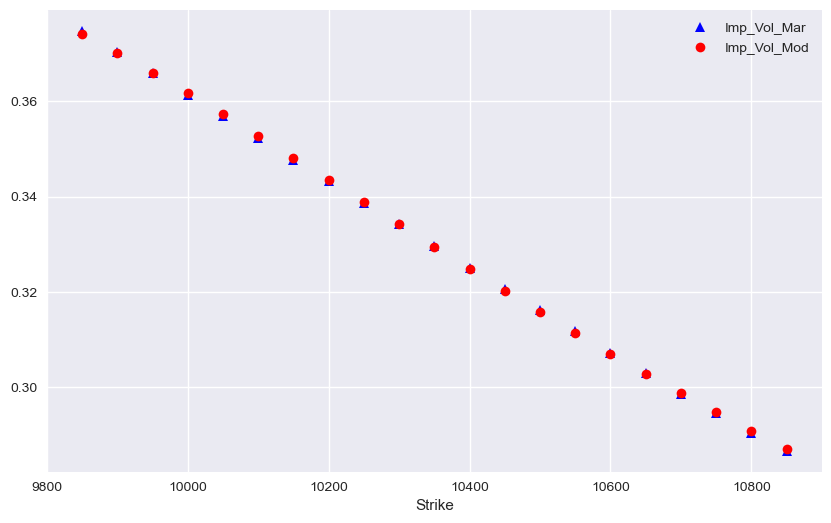

In [408]:
options = calc_imp_vols(options_call)
options.set_index('Strike')[['Imp_Vol_Mar', 'Imp_Vol_Mod']].plot(
                figsize=(10, 6), style=['b^', 'ro']);

In [410]:
options

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,Model,Imp_Vol_Mod,Imp_Vol_Mar
155,/GDAX98500F0.EX,2020-05-15,2020-06-19,CALL,9850,750.4,37.36,749.596966,0.374141,0.374845
157,/GDAX99000F0.EX,2020-05-15,2020-06-19,CALL,9900,713.7,36.87,713.366521,0.370153,0.370440
159,/GDAX99500F0.EX,2020-05-15,2020-06-19,CALL,9950,677.5,36.40,677.607396,0.366001,0.365910
161,/GDAX100000F0.EX,2020-05-15,2020-06-19,CALL,10000,642.0,35.92,642.360112,0.361704,0.361404
163,/GDAX100500F0.EX,2020-05-15,2020-06-19,CALL,10050,607.2,35.45,607.670928,0.357284,0.356897
165,/GDAX101000F0.EX,2020-05-15,2020-06-19,CALL,10100,573.1,34.97,573.591133,0.352763,0.352364
167,/GDAX101500F0.EX,2020-05-15,2020-06-19,CALL,10150,539.7,34.49,540.176173,0.348164,0.347782
169,/GDAX102000F0.EX,2020-05-15,2020-06-19,CALL,10200,507.2,34.02,507.484627,0.343513,0.343286
171,/GDAX102500F0.EX,2020-05-15,2020-06-19,CALL,10250,475.4,33.53,475.577079,0.338832,0.338692
173,/GDAX103000F0.EX,2020-05-15,2020-06-19,CALL,10300,444.5,33.06,444.514909,0.334143,0.334132


In [412]:
options_call['Imp_Vol'] = options_call['Imp_Vol'] / 100
options_call

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,Model,Imp_Vol_Mod,Imp_Vol_Mar
155,/GDAX98500F0.EX,2020-05-15,2020-06-19,CALL,9850,750.4,0.3736,749.596966,0.374141,0.374845
157,/GDAX99000F0.EX,2020-05-15,2020-06-19,CALL,9900,713.7,0.3687,713.366521,0.370153,0.370440
159,/GDAX99500F0.EX,2020-05-15,2020-06-19,CALL,9950,677.5,0.3640,677.607396,0.366001,0.365910
161,/GDAX100000F0.EX,2020-05-15,2020-06-19,CALL,10000,642.0,0.3592,642.360112,0.361704,0.361404
163,/GDAX100500F0.EX,2020-05-15,2020-06-19,CALL,10050,607.2,0.3545,607.670928,0.357284,0.356897
165,/GDAX101000F0.EX,2020-05-15,2020-06-19,CALL,10100,573.1,0.3497,573.591133,0.352763,0.352364
167,/GDAX101500F0.EX,2020-05-15,2020-06-19,CALL,10150,539.7,0.3449,540.176173,0.348164,0.347782
169,/GDAX102000F0.EX,2020-05-15,2020-06-19,CALL,10200,507.2,0.3402,507.484627,0.343513,0.343286
171,/GDAX102500F0.EX,2020-05-15,2020-06-19,CALL,10250,475.4,0.3353,475.577079,0.338832,0.338692
173,/GDAX103000F0.EX,2020-05-15,2020-06-19,CALL,10300,444.5,0.3306,444.514909,0.334143,0.334132


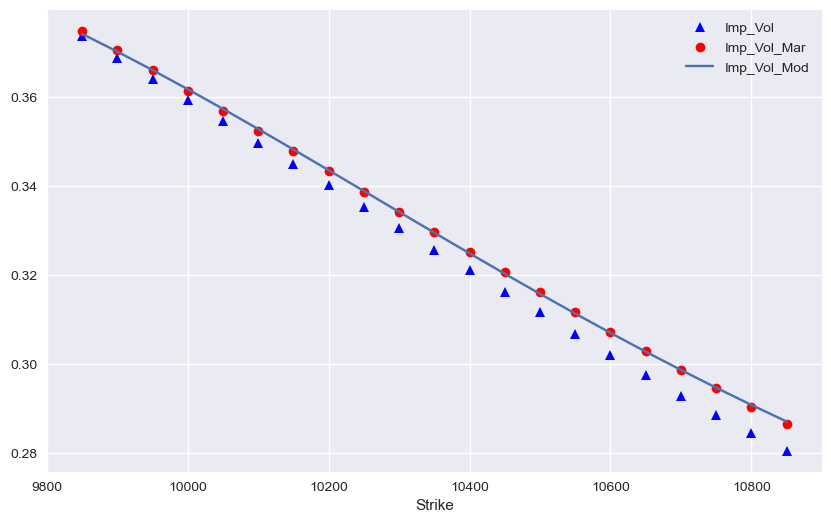

In [414]:
options.set_index('Strike')[['Imp_Vol', 'Imp_Vol_Mar', 'Imp_Vol_Mod']].plot(
                figsize=(10, 6), style=['b^', 'ro']);

In [416]:
options.head()

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,Model,Imp_Vol_Mod,Imp_Vol_Mar
155,/GDAX98500F0.EX,2020-05-15,2020-06-19,CALL,9850,750.4,0.3736,749.596966,0.374141,0.374845
157,/GDAX99000F0.EX,2020-05-15,2020-06-19,CALL,9900,713.7,0.3687,713.366521,0.370153,0.370440
159,/GDAX99500F0.EX,2020-05-15,2020-06-19,CALL,9950,677.5,0.3640,677.607396,0.366001,0.365910
161,/GDAX100000F0.EX,2020-05-15,2020-06-19,CALL,10000,642.0,0.3592,642.360112,0.361704,0.361404
163,/GDAX100500F0.EX,2020-05-15,2020-06-19,CALL,10050,607.2,0.3545,607.670928,0.357284,0.356897


In [418]:
def plot_implied_volatilities(options, model):
    ''' Plots market implied volatilities against model implied ones. '''
    mats = sorted(set(options.Maturity))
    for mat in mats:
        opts = options[options.Maturity == mat]
        plt.figure(figsize=(8, 6))
        plt.subplot(211)
        plt.ylabel('implied volatility')
        plt.plot(opts.Strike, opts.Imp_Vol, 'b', label='Market', lw=1.5)
        plt.plot(opts.Strike, opts.Imp_Vol_Mod, 'ro', label='Model')
        plt.plot(opts.Strike, opts.Imp_Vol_Mar, 'g', label='Market from Model')
        plt.legend(loc=0)
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10,
              min(opts.Imp_Vol) - 0.01, max(opts.Imp_Vol) + 0.01])
        plt.title('Maturity %s' % str(mat)[:10])
        plt.subplot(212)
        wi = 5.0
        diffs = opts.Imp_Vol_Mod.values - opts.Imp_Vol.values
        plt.bar(opts.Strike, diffs, width=wi)
        plt.ylabel('difference')
        ymi = min(diffs) - (max(diffs) - min(diffs)) * 0.1
        yma = max(diffs) + (max(diffs) - min(diffs)) * 0.1
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10, ymi, yma])
        plt.tight_layout()
        plt.savefig('Imp_Volas_DAX_M76.png')

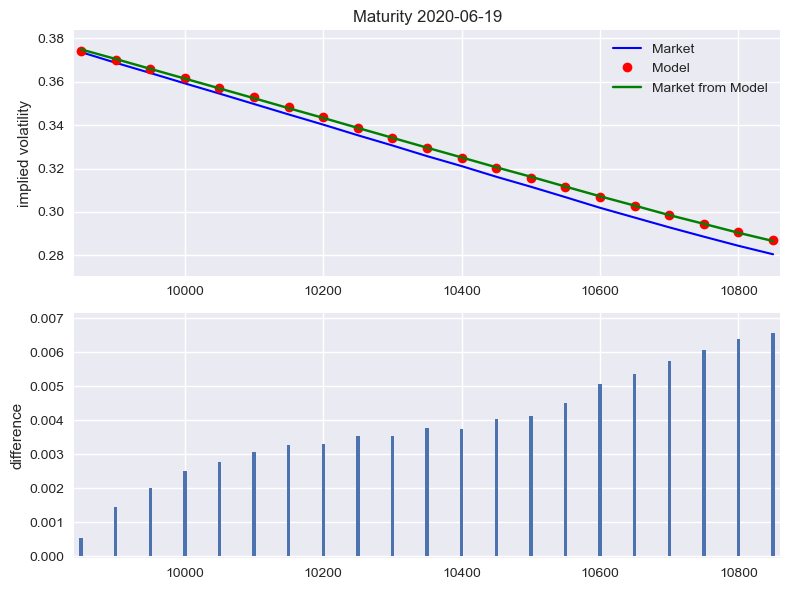

In [420]:
plot_implied_volatilities(options, 'BCC97')

## Delta in Market Premiums vs Model Premiums for Call Options

In [665]:
options

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,Model,Imp_Vol_Mod,Imp_Vol_Mar,Put_Premium,Put_Premium_Model
155,/GDAX98500F0.EX,2020-05-15,2020-06-19,CALL,9850,750.4,0.3736,749.596966,0.374141,0.374845,263.38,263.38
157,/GDAX99000F0.EX,2020-05-15,2020-06-19,CALL,9900,713.7,0.3687,713.366521,0.370153,0.370440,276.68,276.68
159,/GDAX99500F0.EX,2020-05-15,2020-06-19,CALL,9950,677.5,0.3640,677.607396,0.366001,0.365910,290.48,290.48
161,/GDAX100000F0.EX,2020-05-15,2020-06-19,CALL,10000,642.0,0.3592,642.360112,0.361704,0.361404,304.98,304.98
163,/GDAX100500F0.EX,2020-05-15,2020-06-19,CALL,10050,607.2,0.3545,607.670928,0.357284,0.356897,320.18,320.18
165,/GDAX101000F0.EX,2020-05-15,2020-06-19,CALL,10100,573.1,0.3497,573.591133,0.352763,0.352364,336.08,336.08
167,/GDAX101500F0.EX,2020-05-15,2020-06-19,CALL,10150,539.7,0.3449,540.176173,0.348164,0.347782,352.68,352.68
169,/GDAX102000F0.EX,2020-05-15,2020-06-19,CALL,10200,507.2,0.3402,507.484627,0.343513,0.343286,370.18,370.18
171,/GDAX102500F0.EX,2020-05-15,2020-06-19,CALL,10250,475.4,0.3353,475.577079,0.338832,0.338692,388.38,388.38
173,/GDAX103000F0.EX,2020-05-15,2020-06-19,CALL,10300,444.5,0.3306,444.514909,0.334143,0.334132,407.48,407.48


In [661]:
# Subplots incl Delta View on Option Prices Comparison - Market vs Model


def plot_market_model_valuation(options, model):
    ''' Plots market premiums against model implied ones. '''
    mats = sorted(set(options.Maturity))
    for mat in mats:
        opts = options[options.Maturity == mat]
        plt.figure(figsize=(8, 6))
        plt.subplot(211)
        plt.ylabel('Option prices')
        plt.plot(opts.Strike, opts.Close, 'b', label='market', lw=1.5)
        plt.plot(opts.Strike, opts.Model, 'ro', label='model')
        plt.legend(loc=0)
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10,
              min(opts.Close) - 20, max(opts.Close) + 20])
        plt.title('Maturity %s' % str(mat)[:10])
        plt.subplot(212)
        wi = 5.0
        diffs = opts.Close.values - opts.Model.values
        plt.bar(opts.Strike, diffs, width=wi)
        plt.ylabel('difference')
        ymi = min(diffs) - (max(diffs) - min(diffs)) * 0.1
        yma = max(diffs) + (max(diffs) - min(diffs)) * 0.1
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10, ymi, yma])
        plt.tight_layout()
        plt.savefig('Valuation_DAX_M76.png')

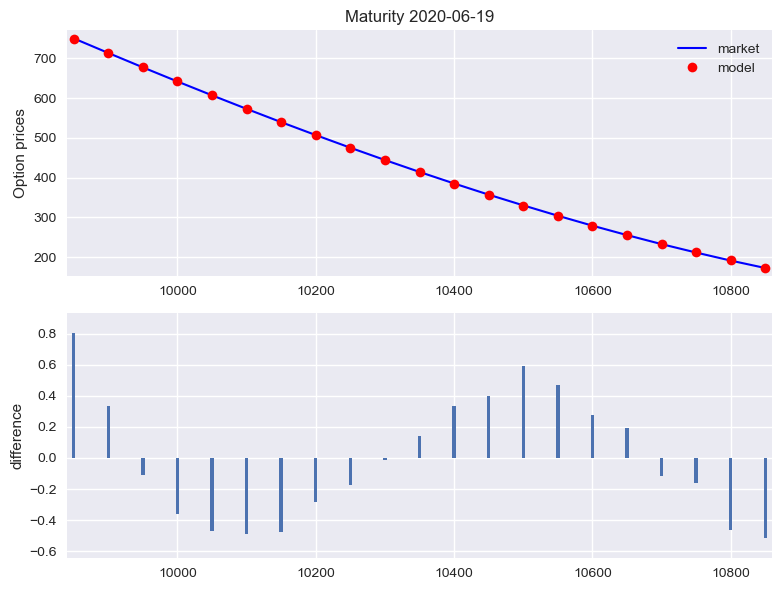

In [663]:
plot_market_model_valuation(options, 'BCC97')

## Derivation of Put Premiums according to Merton Model

In [635]:
# Option Selection (from Puts only)
tol = 0.05
options_put = df_put[(np.abs(df_put['Strike'] - S0) / S0) < tol]
mats = sorted(set(options_put['Maturity']))
options_put = options_put[options_put['Maturity'] == mats[0]]
options_put['Imp_Vol'] = options_put['Imp_Vol'] / 100
options_put

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol
156,/GDAX98500R0.EX,2020-05-15,2020-06-19,PUT,9850,283.1,0.3731
158,/GDAX99000R0.EX,2020-05-15,2020-06-19,PUT,9900,296.3,0.3684
160,/GDAX99500R0.EX,2020-05-15,2020-06-19,PUT,9950,310.1,0.3637
162,/GDAX100000R0.EX,2020-05-15,2020-06-19,PUT,10000,324.7,0.3589
164,/GDAX100500R0.EX,2020-05-15,2020-06-19,PUT,10050,340.1,0.3542
166,/GDAX101000R0.EX,2020-05-15,2020-06-19,PUT,10100,355.9,0.3494
168,/GDAX101500R0.EX,2020-05-15,2020-06-19,PUT,10150,372.5,0.3446
170,/GDAX102000R0.EX,2020-05-15,2020-06-19,PUT,10200,390.0,0.3399
172,/GDAX102500R0.EX,2020-05-15,2020-06-19,PUT,10250,408.3,0.3352
174,/GDAX103000R0.EX,2020-05-15,2020-06-19,PUT,10300,427.5,0.3304


In [815]:
options_call

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,Model,Imp_Vol_Mod,Imp_Vol_Mar,Put_Premium_Model
155,/GDAX98500F0.EX,2020-05-15,2020-06-19,CALL,9850,750.4,0.3736,749.586230,0.376772,0.377482,268.103735
157,/GDAX99000F0.EX,2020-05-15,2020-06-19,CALL,9900,713.7,0.3687,713.365148,0.372697,0.372985,281.427713
159,/GDAX99500F0.EX,2020-05-15,2020-06-19,CALL,9950,677.5,0.3640,677.611696,0.368460,0.368365,295.251692
161,/GDAX100000F0.EX,2020-05-15,2020-06-19,CALL,10000,642.0,0.3592,642.367169,0.364079,0.363773,309.775670
163,/GDAX100500F0.EX,2020-05-15,2020-06-19,CALL,10050,607.2,0.3545,607.678545,0.359576,0.359183,324.999648
165,/GDAX101000F0.EX,2020-05-15,2020-06-19,CALL,10100,573.1,0.3497,573.597764,0.354973,0.354570,340.923627
167,/GDAX101500F0.EX,2020-05-15,2020-06-19,CALL,10150,539.7,0.3449,540.180841,0.350296,0.349910,357.547605
169,/GDAX102000F0.EX,2020-05-15,2020-06-19,CALL,10200,507.2,0.3402,507.486843,0.345568,0.345340,375.071584
171,/GDAX102500F0.EX,2020-05-15,2020-06-19,CALL,10250,475.4,0.3353,475.576754,0.340812,0.340672,393.295562
173,/GDAX103000F0.EX,2020-05-15,2020-06-19,CALL,10300,444.5,0.3306,444.512266,0.336052,0.336042,412.419540


<Axes: xlabel='Strike'>

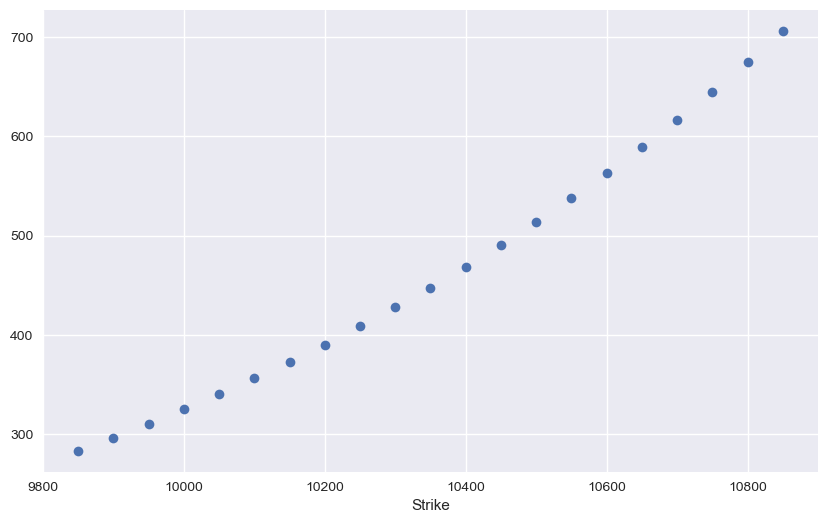

In [639]:
options_put.set_index('Strike')['Close'].plot(style='o', figsize=(10, 6))

<Axes: xlabel='Strike'>

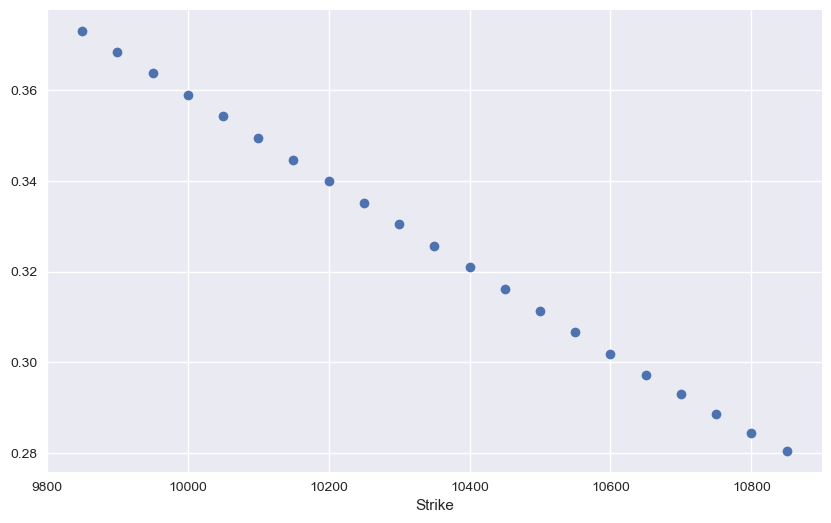

In [641]:
options_put.set_index('Strike')['Imp_Vol'].plot(style='o', figsize=(10, 6))

<Axes: xlabel='Strike'>

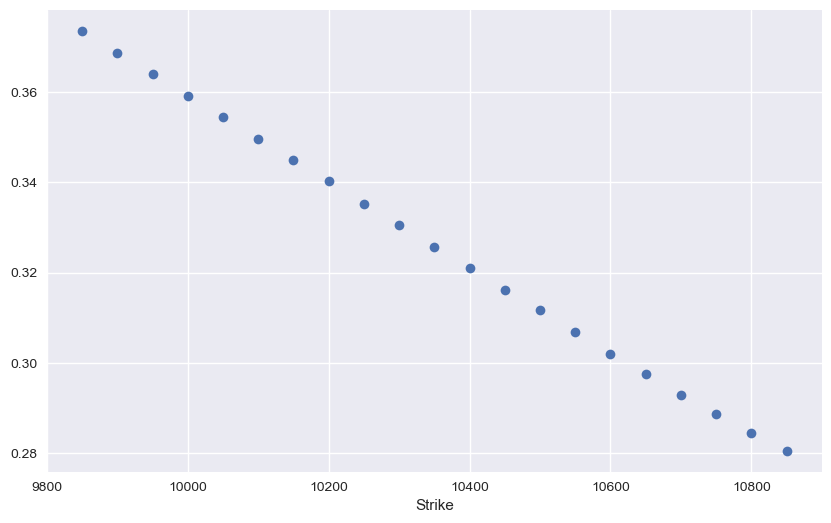

In [643]:
options_call.set_index('Strike')['Imp_Vol'].plot(style='o', figsize=(10, 6))

In [817]:
def calculate_put_premium(data, r, S0):
    ''' Calculate put premium using put-call parity. '''
    
    data['Put_Premium_Model'] = 0.0  # Initialize the new column
    for row in data.index:
        call_value = data.loc[row, 'Close']
        K = data.loc[row, 'Strike']
        t = data.loc[row, 'Date']
        T = data.loc[row, 'Maturity']
        ttm = (T - t).days / 365.0  # Time to maturity in years

        # Calculate put value using put-call parity
        put_value = call_value + K * math.exp(-r * ttm) - S0
        
        # Update the DataFrame
        data.loc[row, 'Put_Premium_Model'] = put_value

    return data

In [819]:
calculate_put_premium(options_call, r, S0)

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,Model,Imp_Vol_Mod,Imp_Vol_Mar,Put_Premium_Model
155,/GDAX98500F0.EX,2020-05-15,2020-06-19,CALL,9850,750.4,0.3736,749.586230,0.376772,0.377482,268.103735
157,/GDAX99000F0.EX,2020-05-15,2020-06-19,CALL,9900,713.7,0.3687,713.365148,0.372697,0.372985,281.427713
159,/GDAX99500F0.EX,2020-05-15,2020-06-19,CALL,9950,677.5,0.3640,677.611696,0.368460,0.368365,295.251692
161,/GDAX100000F0.EX,2020-05-15,2020-06-19,CALL,10000,642.0,0.3592,642.367169,0.364079,0.363773,309.775670
163,/GDAX100500F0.EX,2020-05-15,2020-06-19,CALL,10050,607.2,0.3545,607.678545,0.359576,0.359183,324.999648
165,/GDAX101000F0.EX,2020-05-15,2020-06-19,CALL,10100,573.1,0.3497,573.597764,0.354973,0.354570,340.923627
167,/GDAX101500F0.EX,2020-05-15,2020-06-19,CALL,10150,539.7,0.3449,540.180841,0.350296,0.349910,357.547605
169,/GDAX102000F0.EX,2020-05-15,2020-06-19,CALL,10200,507.2,0.3402,507.486843,0.345568,0.345340,375.071584
171,/GDAX102500F0.EX,2020-05-15,2020-06-19,CALL,10250,475.4,0.3353,475.576754,0.340812,0.340672,393.295562
173,/GDAX103000F0.EX,2020-05-15,2020-06-19,CALL,10300,444.5,0.3306,444.512266,0.336052,0.336042,412.419540


In [823]:
put_premium = pd.DataFrame(options_call['Put_Premium_Model']).reset_index()
put_premium = put_premium.drop('index', axis=1)
put_premium

,Put_Premium_Model
0,268.103735
1,281.427713
2,295.251692
3,309.775670
4,324.999648
5,340.923627
6,357.547605
7,375.071584
8,393.295562
9,412.419540


In [825]:
options_put = options_put.reset_index()
options_put = options_put.drop('index', axis=1)
options_put

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,Put_Premium_Model
0,/GDAX98500R0.EX,2020-05-15,2020-06-19,PUT,9850,283.1,0.3731,268.103735
1,/GDAX99000R0.EX,2020-05-15,2020-06-19,PUT,9900,296.3,0.3684,281.427713
2,/GDAX99500R0.EX,2020-05-15,2020-06-19,PUT,9950,310.1,0.3637,295.251692
3,/GDAX100000R0.EX,2020-05-15,2020-06-19,PUT,10000,324.7,0.3589,309.775670
4,/GDAX100500R0.EX,2020-05-15,2020-06-19,PUT,10050,340.1,0.3542,324.999648
5,/GDAX101000R0.EX,2020-05-15,2020-06-19,PUT,10100,355.9,0.3494,340.923627
6,/GDAX101500R0.EX,2020-05-15,2020-06-19,PUT,10150,372.5,0.3446,357.547605
7,/GDAX102000R0.EX,2020-05-15,2020-06-19,PUT,10200,390.0,0.3399,375.071584
8,/GDAX102500R0.EX,2020-05-15,2020-06-19,PUT,10250,408.3,0.3352,393.295562
9,/GDAX103000R0.EX,2020-05-15,2020-06-19,PUT,10300,427.5,0.3304,412.419540


In [827]:
options_put['Put_Premium_Model'] = put_premium
options_put

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,Put_Premium_Model
0,/GDAX98500R0.EX,2020-05-15,2020-06-19,PUT,9850,283.1,0.3731,268.103735
1,/GDAX99000R0.EX,2020-05-15,2020-06-19,PUT,9900,296.3,0.3684,281.427713
2,/GDAX99500R0.EX,2020-05-15,2020-06-19,PUT,9950,310.1,0.3637,295.251692
3,/GDAX100000R0.EX,2020-05-15,2020-06-19,PUT,10000,324.7,0.3589,309.775670
4,/GDAX100500R0.EX,2020-05-15,2020-06-19,PUT,10050,340.1,0.3542,324.999648
5,/GDAX101000R0.EX,2020-05-15,2020-06-19,PUT,10100,355.9,0.3494,340.923627
6,/GDAX101500R0.EX,2020-05-15,2020-06-19,PUT,10150,372.5,0.3446,357.547605
7,/GDAX102000R0.EX,2020-05-15,2020-06-19,PUT,10200,390.0,0.3399,375.071584
8,/GDAX102500R0.EX,2020-05-15,2020-06-19,PUT,10250,408.3,0.3352,393.295562
9,/GDAX103000R0.EX,2020-05-15,2020-06-19,PUT,10300,427.5,0.3304,412.419540


In [829]:
# Subplots incl Delta View on Put Option Prices Comparison - Market vs Model (using Put Call Parity)


def plot_put_premiums_model_market(options, model):
    ''' Plots market put premiums against model implied ones (using put call parity). '''
    mats = sorted(set(options.Maturity))
    for mat in mats:
        opts = options[options.Maturity == mat]
        plt.figure(figsize=(8, 6))
        plt.subplot(211)
        plt.ylabel('Option prices')
        plt.plot(opts.Strike, opts.Close, 'b', label='market', lw=1.5)
        plt.plot(opts.Strike, opts.Put_Premium_Model, 'ro', label='model')
        plt.legend(loc=0)
        plt.axis([min(opts.Strike) - 40, max(opts.Strike) + 40,
              min(opts.Close) - 40, max(opts.Close) + 40])
        plt.title('Maturity %s' % str(mat)[:10])
        plt.subplot(212)
        wi = 5.0
        diffs = opts.Close.values - opts.Put_Premium_Model.values
        plt.bar(opts.Strike, diffs, width=wi)
        plt.ylabel('difference')
        ymi = min(diffs) - (max(diffs) - min(diffs)) * 0.5
        yma = max(diffs) + (max(diffs) - min(diffs)) * 0.5
        plt.axis([min(opts.Strike) - 40, max(opts.Strike) + 40, ymi, yma])
        plt.tight_layout()
        plt.savefig('Put_Premiums_DAX_M76.png')

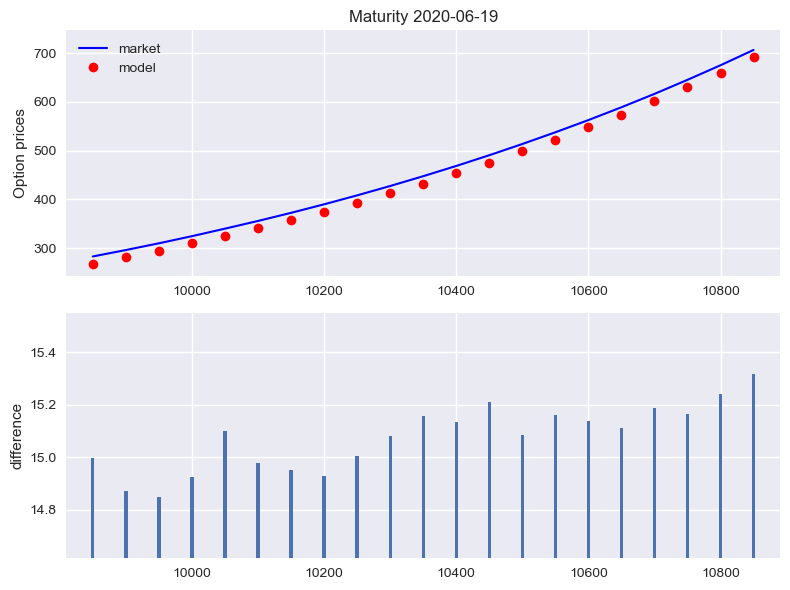

In [831]:
plot_put_premiums_model_market(options_put,  'BCC97')

In [833]:
options_call

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,Model,Imp_Vol_Mod,Imp_Vol_Mar,Put_Premium_Model
155,/GDAX98500F0.EX,2020-05-15,2020-06-19,CALL,9850,750.4,0.3736,749.586230,0.376772,0.377482,268.103735
157,/GDAX99000F0.EX,2020-05-15,2020-06-19,CALL,9900,713.7,0.3687,713.365148,0.372697,0.372985,281.427713
159,/GDAX99500F0.EX,2020-05-15,2020-06-19,CALL,9950,677.5,0.3640,677.611696,0.368460,0.368365,295.251692
161,/GDAX100000F0.EX,2020-05-15,2020-06-19,CALL,10000,642.0,0.3592,642.367169,0.364079,0.363773,309.775670
163,/GDAX100500F0.EX,2020-05-15,2020-06-19,CALL,10050,607.2,0.3545,607.678545,0.359576,0.359183,324.999648
165,/GDAX101000F0.EX,2020-05-15,2020-06-19,CALL,10100,573.1,0.3497,573.597764,0.354973,0.354570,340.923627
167,/GDAX101500F0.EX,2020-05-15,2020-06-19,CALL,10150,539.7,0.3449,540.180841,0.350296,0.349910,357.547605
169,/GDAX102000F0.EX,2020-05-15,2020-06-19,CALL,10200,507.2,0.3402,507.486843,0.345568,0.345340,375.071584
171,/GDAX102500F0.EX,2020-05-15,2020-06-19,CALL,10250,475.4,0.3353,475.576754,0.340812,0.340672,393.295562
173,/GDAX103000F0.EX,2020-05-15,2020-06-19,CALL,10300,444.5,0.3306,444.512266,0.336052,0.336042,412.419540


In [845]:
options_put

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,Put_Premium_Model
0,/GDAX98500R0.EX,2020-05-15,2020-06-19,PUT,9850,283.1,0.3731,268.103735
1,/GDAX99000R0.EX,2020-05-15,2020-06-19,PUT,9900,296.3,0.3684,281.427713
2,/GDAX99500R0.EX,2020-05-15,2020-06-19,PUT,9950,310.1,0.3637,295.251692
3,/GDAX100000R0.EX,2020-05-15,2020-06-19,PUT,10000,324.7,0.3589,309.775670
4,/GDAX100500R0.EX,2020-05-15,2020-06-19,PUT,10050,340.1,0.3542,324.999648
5,/GDAX101000R0.EX,2020-05-15,2020-06-19,PUT,10100,355.9,0.3494,340.923627
6,/GDAX101500R0.EX,2020-05-15,2020-06-19,PUT,10150,372.5,0.3446,357.547605
7,/GDAX102000R0.EX,2020-05-15,2020-06-19,PUT,10200,390.0,0.3399,375.071584
8,/GDAX102500R0.EX,2020-05-15,2020-06-19,PUT,10250,408.3,0.3352,393.295562
9,/GDAX103000R0.EX,2020-05-15,2020-06-19,PUT,10300,427.5,0.3304,412.419540


# Calibration of Put Options according to Merton Model (M76)

In [852]:
def M76_put_value(S0, K, T, r, v0, lamb, mu, delta):
    ''' Valuation of European call option in M76 model via Lewis (2001)
    Fourier-based approach.

    Parameters
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump

    Returns
    =======
    call_value: float
        present value of European call option
    '''
    sigma = np.sqrt(v0)
    int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r,
                                               sigma, lamb, mu, delta),
                     0, np.inf, limit=250)[0]
    put_value = max(0, np.exp(-r * T) * np.sqrt(S0 * K) - S0 /
                     np.pi * int_value)
    return put_value

In [856]:
def M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta):
    ''' Valuation of European call option in M76 model via Lewis (2001)
    Fourier-based approach: integration function.

    Parameter definitions see function M76_call_value.'''
    char_func_value = M76_char_func_sa(u - 0.5 * 1j, T, r, sigma,
                                       lamb, mu, delta)
    int_func_value = 1 / (u ** 2 + 0.25) \
        * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return int_func_value

In [858]:
def M76_char_func(u, T, lamb, mu, delta):
    ''' Valuation of European call option in M76 model via Lewis (2001)
    Fourier-based approach: characteristic function.

    Parameter definitions see function M76_call_value.'''
    omega = -lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    char_func_value = np.exp((1j * u * omega + lamb *
                              (np.exp(1j * u * mu - u ** 2 *
                                      delta ** 2 * 0.5) - 1)) * T)
    return char_func_value


def M76_char_func_sa(u, T, r, sigma, lamb, mu, delta):
    ''' Valuation of European call option in M76 model via Lewis (2001)
    Fourier-based approach: characteristic function "jump component".

    Parameter definitions see function M76_call_value.'''
    omega = r - 0.5 * sigma ** 2 - lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    char_func_value = np.exp((1j * u * omega - 0.5 * u ** 2 * sigma ** 2 +
                              lamb * (np.exp(1j * u * mu -
                                             u ** 2 * delta ** 2 * 0.5) -
                                      1)) * T)
    return char_func_value

In [874]:
import numpy as np
from scipy.integrate import quad
from CIR_zcb_valuation import B
import warnings
warnings.simplefilter('ignore')

In [876]:
# M76 Parameters
lamb = 0.25
mu = -0.2
delta = 0.1
v0 = 0.04
sigma = np.sqrt(v0)

# General Parameters
S0 = 10337.02
K = 11200.0
T = 0.09589
r = -0.005

In [878]:
kappa_r, theta_r, sigma_r, r0, T = 0.3, 0.04, 0.1, 0.04, T
B0T = B([kappa_r, theta_r, sigma_r, r0, T])  # discount factor
r = -np.log(B0T) / T

In [987]:
r

0.03999940006780879

In [880]:
print("M76 Put Value   %10.4f"
          % M76_put_value(S0, K, T, r, v0, lamb, mu, delta))

M76 Put Value     787.6784


In [990]:
r = -0.005

In [992]:
i = 0; min_RMSE = 500.
def M76_error_function(p0):
    global i, min_RMSE
    sigma, lamb, mu, delta = p0
    if sigma < 0.0 or delta < 0.0 or lamb < 0.0:
        return 500.0
    se = []
    for row, option in options_put.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        model_value = M76_put_value(S0, option['Strike'], T,
                                         r, sigma, lamb, mu, delta)
        se.append((model_value - option['Close']) ** 2)
    RMSE = math.sqrt(sum(se) / len(se))
    min_RMSE = min(min_RMSE, RMSE)
    if i % 100 == 0:
        print ('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (RMSE, min_RMSE))
    i += 1
    return RMSE

In [994]:
%%time
import scipy.optimize as sop
np.set_printoptions(suppress=True,
                    formatter={'all': lambda x: '%6.3f' % x})
p0 = sop.brute(M76_error_function, ((0.10, 0.25, 0.025),
                   (0.10, 0.80, 0.10), (-0.40, 0.00, 0.10),
                   (0.00, 0.12, 0.02)), finish=None)

   0 | [ 0.100  0.100 -0.400  0.000] |  29.822 |  29.822
 100 | [ 0.100  0.500 -0.400  0.080] |  36.655 |  19.691
 200 | [ 0.125  0.200 -0.300  0.040] |  39.356 |  19.691
 300 | [ 0.125  0.600 -0.200  0.000] |  49.528 |  19.691
 400 | [ 0.150  0.300 -0.200  0.080] |  74.563 |  19.691
 500 | [ 0.150  0.700 -0.100  0.040] |  71.358 |  19.691
 600 | [ 0.175  0.500 -0.400  0.000] | 155.685 |  19.691
 700 | [ 0.200  0.200 -0.400  0.080] | 155.062 |  19.691
 800 | [ 0.200  0.600 -0.300  0.040] | 179.592 |  19.691
 900 | [ 0.225  0.300 -0.200  0.000] | 178.198 |  19.691
1000 | [ 0.225  0.700 -0.200  0.080] | 195.934 |  19.691
CPU times: total: 27.6 s
Wall time: 48.8 s


In [996]:
%%time
opt = sop.fmin(M76_error_function, p0, xtol=0.00001,
                    ftol=0.00001, maxiter=750, maxfun=1500)

1100 | [ 0.065  0.387 -0.835  0.066] |   1.686 |   1.686
1200 | [ 0.065  0.418 -0.760  0.042] |   1.657 |   1.657
1300 | [ 0.064  0.479 -0.647  0.002] |   1.592 |   1.590
Optimization terminated successfully.
         Current function value: 1.589002
         Iterations: 252
         Function evaluations: 429
CPU times: total: 15.5 s
Wall time: 23.7 s


In [998]:
i = 0
M76_error_function(p0)

   0 | [ 0.100  0.300 -0.400  0.100] |  19.691 |   1.589


19.690672775382176

In [1000]:
i = 0
M76_error_function(opt)

   0 | [ 0.064  0.482 -0.644  0.000] |   1.589 |   1.589


1.589001541189983

In [1002]:
options_put

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,Put_Premium_Model,Model,Imp_Vol_Mod,Imp_Vol_Mar
0,/GDAX98500R0.EX,2020-05-15,2020-06-19,PUT,9850,283.1,0.3731,268.103735,282.213017,0.403304,0.404083
1,/GDAX99000R0.EX,2020-05-15,2020-06-19,PUT,9900,296.3,0.3684,281.427713,295.221773,0.398667,0.399599
2,/GDAX99500R0.EX,2020-05-15,2020-06-19,PUT,9950,310.1,0.3637,295.251692,309.016455,0.394200,0.395121
3,/GDAX100000R0.EX,2020-05-15,2020-06-19,PUT,10000,324.7,0.3589,309.775670,323.613701,0.389887,0.390797
4,/GDAX100500R0.EX,2020-05-15,2020-06-19,PUT,10050,340.1,0.3542,324.999648,339.028122,0.385715,0.386601
5,/GDAX101000R0.EX,2020-05-15,2020-06-19,PUT,10100,355.9,0.3494,340.923627,355.272201,0.381668,0.382181
6,/GDAX101500R0.EX,2020-05-15,2020-06-19,PUT,10150,372.5,0.3446,357.547605,372.356216,0.377732,0.377848
7,/GDAX102000R0.EX,2020-05-15,2020-06-19,PUT,10200,390.0,0.3399,375.071584,390.288178,0.373890,0.373659
8,/GDAX102500R0.EX,2020-05-15,2020-06-19,PUT,10250,408.3,0.3352,393.295562,409.073789,0.370126,0.369512
9,/GDAX103000R0.EX,2020-05-15,2020-06-19,PUT,10300,427.5,0.3304,412.419540,428.716417,0.366424,0.365465


In [1004]:
def generate_plot(opt, options_put):
    sigma, lamb, mu, delta = opt
    options_put['Model'] = 0.0
    for row, option in options_put.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        options_put.loc[row, 'Model'] = M76_put_value(S0, option['Strike'],
                                    T, r, sigma, lamb, mu, delta)
    options_put = options_put.set_index('Strike')
    fig, ax = plt.subplots(2, sharex=True, figsize=(8, 7))
    options_put[['Close', 'Model']].plot(style=['b-', 'ro'],
                    title='Put Options with Maturity %s' % str(option['Maturity'])[:10], ax=ax[0])
    ax[0].set_ylabel('Option premiums')
    xv = options_put.index.values
    ax[1] = plt.bar(xv - 5 / 2., options_put['Model'] - options_put['Close'], 
                    width=5)
    plt.ylabel('Difference in option premiums')
    plt.xlim(min(xv) - 10, max(xv) + 10)
    plt.tight_layout()

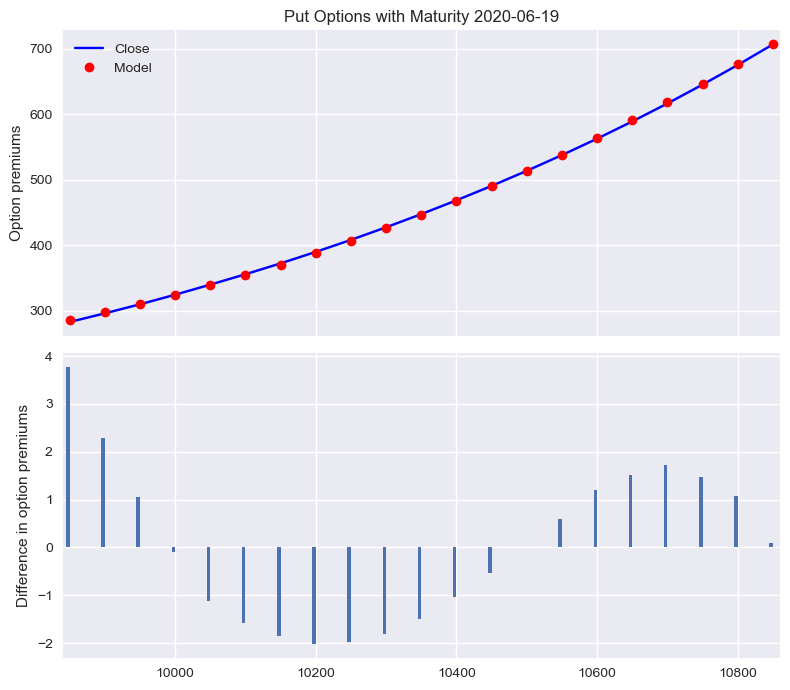

In [1006]:
generate_plot(opt, options_put)
plt.savefig('M76_Premiums_Put Options_DAX_2020.png')

In [1008]:
options_put

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,Put_Premium_Model,Model,Imp_Vol_Mod,Imp_Vol_Mar
0,/GDAX98500R0.EX,2020-05-15,2020-06-19,PUT,9850,283.1,0.3731,268.103735,286.878078,0.403304,0.404083
1,/GDAX99000R0.EX,2020-05-15,2020-06-19,PUT,9900,296.3,0.3684,281.427713,298.580098,0.398667,0.399599
2,/GDAX99500R0.EX,2020-05-15,2020-06-19,PUT,9950,310.1,0.3637,295.251692,311.143346,0.394200,0.395121
3,/GDAX100000R0.EX,2020-05-15,2020-06-19,PUT,10000,324.7,0.3589,309.775670,324.602083,0.389887,0.390797
4,/GDAX100500R0.EX,2020-05-15,2020-06-19,PUT,10050,340.1,0.3542,324.999648,338.987767,0.385715,0.386601
5,/GDAX101000R0.EX,2020-05-15,2020-06-19,PUT,10100,355.9,0.3494,340.923627,354.328720,0.381668,0.382181
6,/GDAX101500R0.EX,2020-05-15,2020-06-19,PUT,10150,372.5,0.3446,357.547605,370.649835,0.377732,0.377848
7,/GDAX102000R0.EX,2020-05-15,2020-06-19,PUT,10200,390.0,0.3399,375.071584,387.972315,0.373890,0.373659
8,/GDAX102500R0.EX,2020-05-15,2020-06-19,PUT,10250,408.3,0.3352,393.295562,406.313464,0.370126,0.369512
9,/GDAX103000R0.EX,2020-05-15,2020-06-19,PUT,10300,427.5,0.3304,412.419540,425.686512,0.366424,0.365465


In [1010]:
T

0.09589

In [1012]:
r

-0.005

In [1014]:
def calc_imp_vols(data):
    data['Imp_Vol_Mod'] = 0.0
    data['Imp_Vol_Mar'] = 0.0
    tol = 0.30  # tolerance for moneyness
    for row in data.index:
        t = data['Date'][row]
        T = data['Maturity'][row]
        ttm = (T - t).days / 365.
        forward = np.exp(r * ttm) * S0
        if (abs(data['Strike'][row] - forward) / forward) < tol:
            put = put_option(S0, data['Strike'][row], t, T, r, 0.2)
            data['Imp_Vol_Mod'][row] = put.imp_vol(data['Model'][row])
            data['Imp_Vol_Mar'][row] = put.imp_vol(data['Close'][row])
    return data

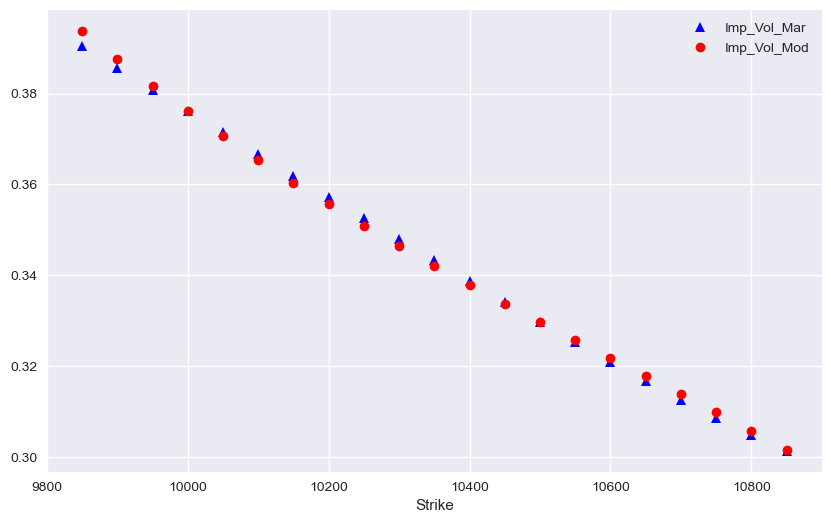

In [1016]:
options_put = calc_imp_vols(options_put)
options_put.set_index('Strike')[['Imp_Vol_Mar', 'Imp_Vol_Mod']].plot(
                figsize=(10, 6), style=['b^', 'ro']);

In [1018]:
options_put

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,Put_Premium_Model,Model,Imp_Vol_Mod,Imp_Vol_Mar
0,/GDAX98500R0.EX,2020-05-15,2020-06-19,PUT,9850,283.1,0.3731,268.103735,286.878078,0.393824,0.390544
1,/GDAX99000R0.EX,2020-05-15,2020-06-19,PUT,9900,296.3,0.3684,281.427713,298.580098,0.387665,0.385718
2,/GDAX99500R0.EX,2020-05-15,2020-06-19,PUT,9950,310.1,0.3637,295.251692,311.143346,0.381755,0.380877
3,/GDAX100000R0.EX,2020-05-15,2020-06-19,PUT,10000,324.7,0.3589,309.775670,324.602083,0.376085,0.376166
4,/GDAX100500R0.EX,2020-05-15,2020-06-19,PUT,10050,340.1,0.3542,324.999648,338.987767,0.370646,0.371557
5,/GDAX101000R0.EX,2020-05-15,2020-06-19,PUT,10100,355.9,0.3494,340.923627,354.328720,0.365427,0.366699
6,/GDAX101500R0.EX,2020-05-15,2020-06-19,PUT,10150,372.5,0.3446,357.547605,370.649835,0.360414,0.361897
7,/GDAX102000R0.EX,2020-05-15,2020-06-19,PUT,10200,390.0,0.3399,375.071584,387.972315,0.355594,0.357205
8,/GDAX102500R0.EX,2020-05-15,2020-06-19,PUT,10250,408.3,0.3352,393.295562,406.313464,0.350950,0.352519
9,/GDAX103000R0.EX,2020-05-15,2020-06-19,PUT,10300,427.5,0.3304,412.419540,425.686512,0.346467,0.347892


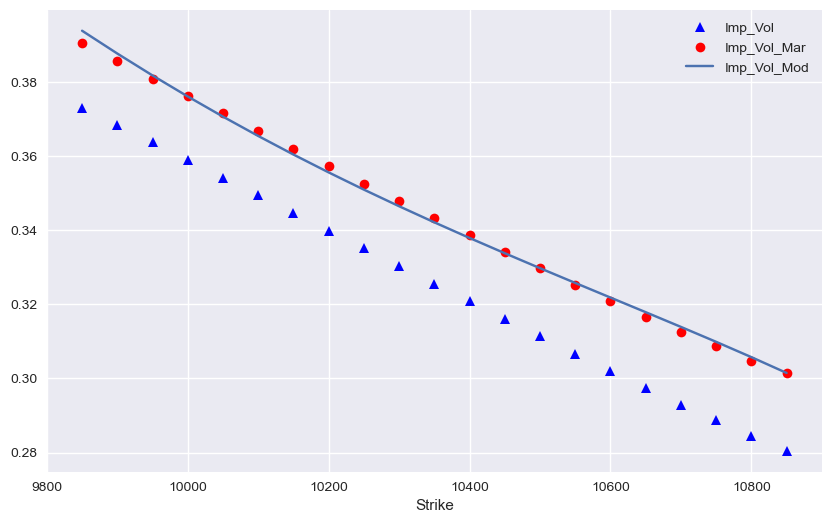

In [1020]:
options_put.set_index('Strike')[['Imp_Vol', 'Imp_Vol_Mar', 'Imp_Vol_Mod']].plot(
                figsize=(10, 6), style=['b^', 'ro']);

In [1026]:
def plot_implied_volatilities(options, model):
    ''' Plots market implied volatilities against model implied ones. '''
    mats = sorted(set(options.Maturity))
    for mat in mats:
        opts = options[options.Maturity == mat]
        plt.figure(figsize=(8, 6))
        plt.subplot(211)
        plt.ylabel('Implied Volatilities')
        plt.plot(opts.Strike, opts.Imp_Vol, 'b', label='Base Data', lw=1.5)
        plt.plot(opts.Strike, opts.Imp_Vol_Mod, 'ro', label='Model')
        plt.plot(opts.Strike, opts.Imp_Vol_Mar, 'g', label='Market from Model')
        plt.legend(loc=0)
        plt.axis([min(opts.Strike) - 20, max(opts.Strike) + 20,
              min(opts.Imp_Vol) - 0.01, max(opts.Imp_Vol) + 0.04])
        plt.title('Maturity %s' % str(mat)[:10])
        plt.subplot(212)
        wi = 5.0
        diffs = opts.Imp_Vol_Mod.values - opts.Imp_Vol.values
        plt.bar(opts.Strike, diffs, width=wi)
        plt.ylabel('Difference')
        ymi = min(diffs) - (max(diffs) - min(diffs)) * 0.1
        yma = max(diffs) + (max(diffs) - min(diffs)) * 0.1
        plt.axis([min(opts.Strike) - 20, max(opts.Strike) + 20, ymi, yma])
        plt.tight_layout()
        plt.savefig('Imp_Volas_DAX_2020_M76_Puts.png')

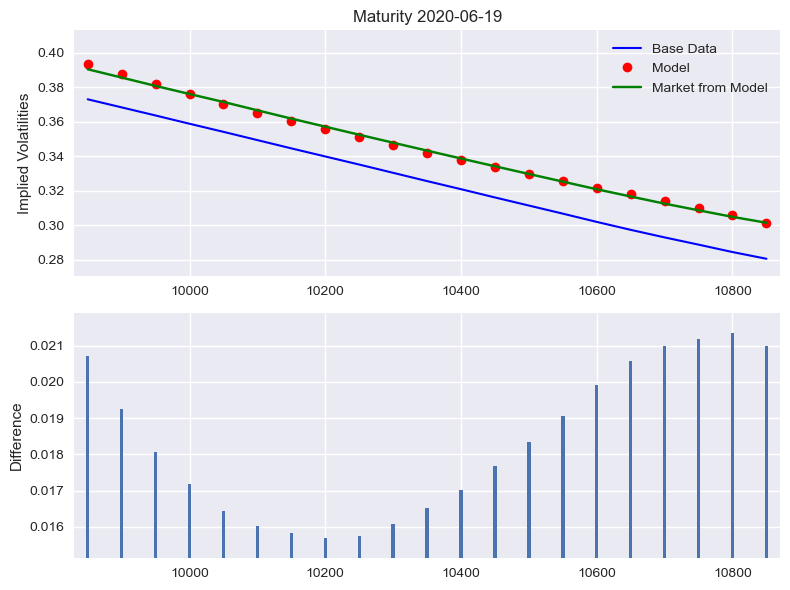

In [1028]:
plot_implied_volatilities(options_put, 'BCC97')

## Delta in Market Premiums vs Model Premiums for Call Options

In [1031]:
options_put

,Instrument,Date,Maturity,PUTCALLIND,Strike,Close,Imp_Vol,Put_Premium_Model,Model,Imp_Vol_Mod,Imp_Vol_Mar
0,/GDAX98500R0.EX,2020-05-15,2020-06-19,PUT,9850,283.1,0.3731,268.103735,286.878078,0.393824,0.390544
1,/GDAX99000R0.EX,2020-05-15,2020-06-19,PUT,9900,296.3,0.3684,281.427713,298.580098,0.387665,0.385718
2,/GDAX99500R0.EX,2020-05-15,2020-06-19,PUT,9950,310.1,0.3637,295.251692,311.143346,0.381755,0.380877
3,/GDAX100000R0.EX,2020-05-15,2020-06-19,PUT,10000,324.7,0.3589,309.775670,324.602083,0.376085,0.376166
4,/GDAX100500R0.EX,2020-05-15,2020-06-19,PUT,10050,340.1,0.3542,324.999648,338.987767,0.370646,0.371557
5,/GDAX101000R0.EX,2020-05-15,2020-06-19,PUT,10100,355.9,0.3494,340.923627,354.328720,0.365427,0.366699
6,/GDAX101500R0.EX,2020-05-15,2020-06-19,PUT,10150,372.5,0.3446,357.547605,370.649835,0.360414,0.361897
7,/GDAX102000R0.EX,2020-05-15,2020-06-19,PUT,10200,390.0,0.3399,375.071584,387.972315,0.355594,0.357205
8,/GDAX102500R0.EX,2020-05-15,2020-06-19,PUT,10250,408.3,0.3352,393.295562,406.313464,0.350950,0.352519
9,/GDAX103000R0.EX,2020-05-15,2020-06-19,PUT,10300,427.5,0.3304,412.419540,425.686512,0.346467,0.347892


In [1041]:
# Subplots incl Delta View on Option Prices Comparison - Market vs Model

def plot_market_model_valuation(options, model):
    ''' Plots market premiums against model implied ones. '''
    mats = sorted(set(options.Maturity))
    for mat in mats:
        opts = options[options.Maturity == mat]
        plt.figure(figsize=(8, 6))
        plt.subplot(211)
        plt.ylabel('Option prices')
        plt.plot(opts.Strike, opts.Close, 'b', label='Market', lw=1.5)
        plt.plot(opts.Strike, opts.Model, 'ro', label='Model')
        plt.legend(loc=0)
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10,
              min(opts.Close) - 20, max(opts.Close) + 20])
        plt.title('Put Options with Maturity %s' % str(mat)[:10])
        plt.subplot(212)
        wi = 5.0
        diffs = opts.Close.values - opts.Model.values
        plt.bar(opts.Strike, diffs, width=wi)
        plt.ylabel('Difference in Put Premiums')
        ymi = min(diffs) - (max(diffs) - min(diffs)) * 0.1
        yma = max(diffs) + (max(diffs) - min(diffs)) * 0.1
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10, ymi, yma])
        plt.tight_layout()
        plt.savefig('Valuation_DAX_2020_M76_Puts.png')

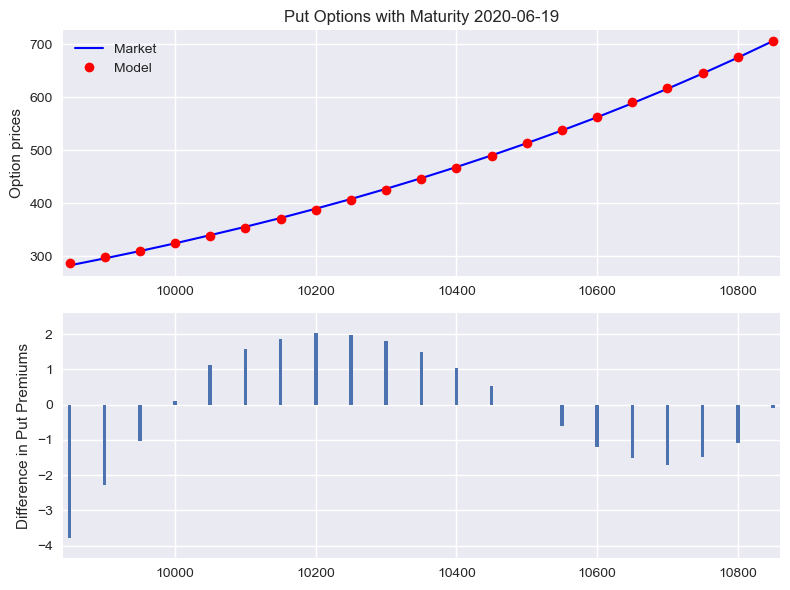

In [1043]:
plot_market_model_valuation(options_put, 'BCC97')

# Close of Code

In [983]:
r

0.03999940006780879

In [985]:
S0

10337.02